In [2]:
from datasets import load_dataset


In [3]:
emotions = load_dataset("emotion")


/home/ardalan/miniconda3/envs/ocr/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Using custom data configuration default
Found cached dataset emotion (/home/ardalan/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)
100%|██████████| 3/3 [00:00<00:00, 972.03it/s]


In [4]:
train_ds = emotions["train"]


## Character Tokenization


In [5]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)


In [6]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}


In [7]:
import torch
import torch.nn.functional as F


In [8]:
input_ids = [token2idx[token] for token in tokenized_text]
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))


## Word Tokenization


In [9]:
tokenized_text = text.split()
tokenized_text


['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']

In [10]:
token2idx = {word: idx for idx, word in enumerate(sorted(set(tokenized_text)))}
input_ids = [token2idx[token] for token in token2idx]
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape


torch.Size([8, 8])

## Subword Tokenization


In [11]:
from transformers import AutoTokenizer


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 5 files to the new cache system


  0%|          | 0/5 [00:02<?, ?it/s]
There was a problem when trying to move your cache:

  File "/home/ardalan/miniconda3/envs/ocr/lib/python3.9/site-packages/transformers/utils/hub.py", line 1128, in <module>
    move_cache()

  File "/home/ardalan/miniconda3/envs/ocr/lib/python3.9/site-packages/transformers/utils/hub.py", line 1071, in move_cache
    hub_metadata[url] = get_hub_metadata(url, token=token)

  File "/home/ardalan/miniconda3/envs/ocr/lib/python3.9/site-packages/transformers/utils/hub.py", line 996, in get_hub_metadata
    huggingface_hub.file_download._raise_for_status(r)

AttributeError: module 'huggingface_hub.file_download' has no attribute '_raise_for_status'

Please file an issue at https://github.com/huggingface/transformers/issues/new/choose and copy paste this whole message and we will do our best to help.


In [12]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


In [13]:
from transformers import DistilBertTokenizer


In [14]:
tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)


In [15]:
encoded_text = tokenizer(text)
encoded_text


{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [16]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '.',
 '[SEP]']

In [17]:
tokenizer.convert_tokens_to_string(tokens)


'[CLS] tokenizing text is a core task of nlp . [SEP]'

## Tokenizing the Whole Dataset


In [18]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


In [19]:
tokenize(emotions["train"][:2])


{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [20]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)


Loading cached processed dataset at /home/ardalan/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-2be26e80a60bb3a7.arrow
Loading cached processed dataset at /home/ardalan/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-a52490ece373d2e9.arrow
Loading cached processed dataset at /home/ardalan/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-02f75626ae428a23.arrow


## Transformers as Feature Extractors


In [21]:
from transformers import AutoModel
import torch

In [22]:
model_ckpt = 'distilbert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [23]:
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
text = "this is a test"
inputs = tokenizer(text, return_tensors='pt')
inputs['input_ids'].shape

torch.Size([1, 6])

In [25]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    output = model(**inputs)
output

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [26]:
output.last_hidden_state[:,0].shape

torch.Size([1, 768])

In [27]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {'hidden_state': last_hidden_state[:,0].cpu().numpy()}

In [28]:
emotions_encoded.set_format('torch', columns=["input_ids", "attention_mask", "label"])


In [29]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

100%|██████████| 2/2 [00:03<00:00,  1.60s/ba]


In [30]:
import numpy as np

In [31]:
X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [32]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [33]:
X_scaled = MinMaxScaler().fit_transform(X_train)

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

In [35]:
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.655691,6.914457,0
1,-2.805612,6.546829,0
2,5.175743,3.390543,3
3,-2.101911,4.815317,2
4,-3.129997,4.794663,3


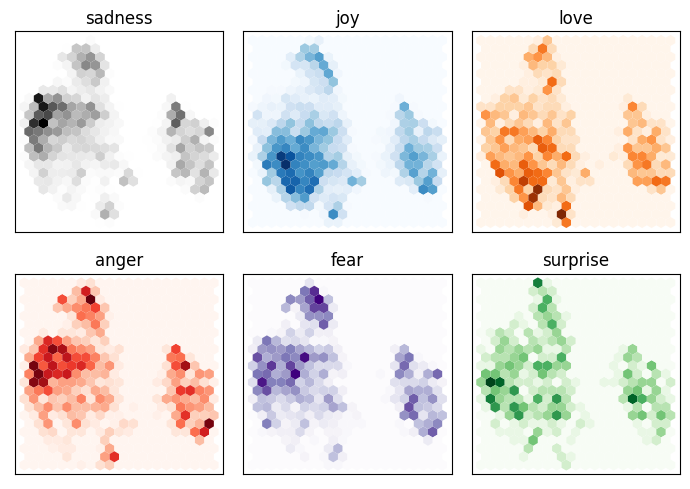

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
        gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()  

## Training a Simple Classifier

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [39]:
from sklearn.dummy import DummyClassifier


In [40]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


In [42]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


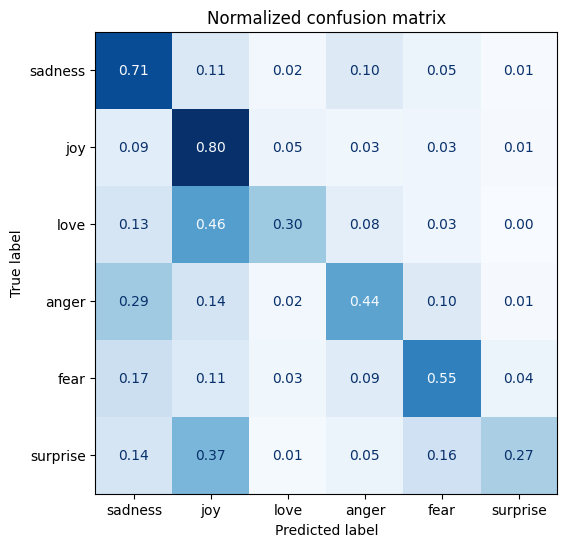

In [43]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## Fine-Tuning Transformers

In [44]:
from transformers import AutoModelForSequenceClassification

In [45]:
model_ckpt = 'distilbert-base-uncased'

In [46]:
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

In [47]:
from sklearn.metrics import f1_score, accuracy_score

In [48]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

In [49]:
from transformers import TrainingArguments

In [50]:
batch_size = 64
epochs = 2
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f'{model_ckpt}-finetuned-emotion'

training_args = TrainingArguments(
    disable_tqdm=False,
    learning_rate=2e-5,
    logging_steps=logging_steps,
    num_train_epochs=epochs,
    output_dir=model_name,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy='epoch',
    push_to_hub=False,
    weight_decay=0.01,
    log_level='error',
    load_best_model_at_end=True,
    save_strategy='epoch'
)


In [51]:
from transformers import Trainer

In [52]:
trainer = Trainer(
    args=training_args,
    compute_metrics=compute_metrics,
    model=model,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['validation'],
    tokenizer=tokenizer,
)


In [53]:
trainer.train()

/home/ardalan/miniconda3/envs/ocr/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 50%|█████     | 250/500 [01:38<01:39,  2.51it/s]

{'loss': 0.8006, 'learning_rate': 1e-05, 'epoch': 1.0}


                                                 
 50%|█████     | 250/500 [01:41<01:39,  2.51it/s]

{'eval_loss': 0.29096582531929016, 'eval_accuracy': 0.92, 'eval_f1': 0.9189320162315394, 'eval_runtime': 3.5759, 'eval_samples_per_second': 559.301, 'eval_steps_per_second': 8.949, 'epoch': 1.0}


100%|██████████| 500/500 [03:22<00:00,  2.50it/s]

{'loss': 0.2364, 'learning_rate': 0.0, 'epoch': 2.0}


                                                 
100%|██████████| 500/500 [03:26<00:00,  2.50it/s]

{'eval_loss': 0.21329852938652039, 'eval_accuracy': 0.928, 'eval_f1': 0.9278189795726945, 'eval_runtime': 3.6133, 'eval_samples_per_second': 553.511, 'eval_steps_per_second': 8.856, 'epoch': 2.0}


100%|██████████| 500/500 [03:27<00:00,  2.41it/s]

{'train_runtime': 207.5952, 'train_samples_per_second': 154.146, 'train_steps_per_second': 2.409, 'train_loss': 0.518522720336914, 'epoch': 2.0}


TrainOutput(global_step=500, training_loss=0.518522720336914, metrics={'train_runtime': 207.5952, 'train_samples_per_second': 154.146, 'train_steps_per_second': 2.409, 'train_loss': 0.518522720336914, 'epoch': 2.0})

In [54]:
preds_output = trainer.predict(emotions_encoded["validation"])

100%|██████████| 32/32 [00:03<00:00,  9.31it/s]


In [55]:
preds_output.metrics

{'test_loss': 0.21329852938652039,
 'test_accuracy': 0.928,
 'test_f1': 0.9278189795726945,
 'test_runtime': 3.5744,
 'test_samples_per_second': 559.541,
 'test_steps_per_second': 8.953}

In [56]:
y_preds = np.argmax(preds_output.predictions, axis=1)

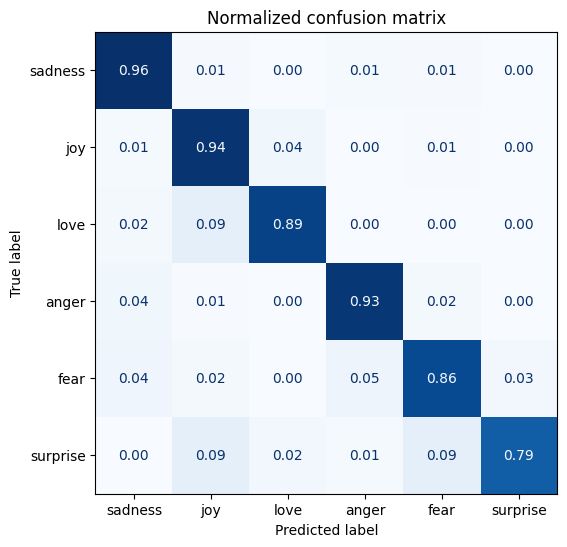

In [57]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [58]:
from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
        if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
        reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
    "predicted_label": pred_label.cpu().numpy()}

In [59]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
forward_pass_with_label, batched=True, batch_size=16)

100%|██████████| 125/125 [00:03<00:00, 33.53ba/s]


In [62]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [63]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [64]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,5.558522
1963,i called myself pro life and voted for perry w...,joy,sadness,5.253808
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.238698
318,i felt ashamed of these feelings and was scare...,fear,sadness,5.140758
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.994029
1274,i am going to several holiday parties and i ca...,joy,sadness,4.838423
1950,i as representative of everything thats wrong ...,surprise,anger,4.773161
1509,i guess this is a memoir so it feels like that...,joy,fear,4.453474
1590,deception from a person i loved very much,anger,love,4.452653
177,im sure much of the advantage is psychological...,sadness,joy,4.311084


In [65]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1226,im feeling terrific and in great shape im opti...,joy,joy,0.016133
578,i got to christmas feeling positive about the ...,joy,joy,0.016516
1020,i feel that the content i have in mind isnt re...,joy,joy,0.016622
1873,i feel practically virtuous this month i have ...,joy,joy,0.016647
4,i can have for a treat or if i am feeling festive,joy,joy,0.016688
222,i am at day and i am feeling terrific,joy,joy,0.016817
11,i was dribbling on mums coffee table looking o...,joy,joy,0.016940
1259,i feel terrific but won t hammer it home,joy,joy,0.016958
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.016970
199,i feel invigorated full of energy ready for th...,joy,joy,0.017048


In [ ]:
# trainer.push_to_hub(commit_message="Training completed!")

In [67]:
from transformers import pipeline
# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

Downloading: 100%|██████████| 268M/268M [05:11<00:00, 860kB/s]  
Downloading: 100%|██████████| 333/333 [00:00<00:00, 356kB/s]
Downloading: 100%|██████████| 232k/232k [00:01<00:00, 183kB/s]  
Downloading: 100%|██████████| 466k/466k [00:01<00:00, 269kB/s]  
Downloading: 100%|██████████| 112/112 [00:00<00:00, 500kB/s]


In [68]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/home/ardalan/miniconda3/envs/ocr/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:89: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  warnings.warn(


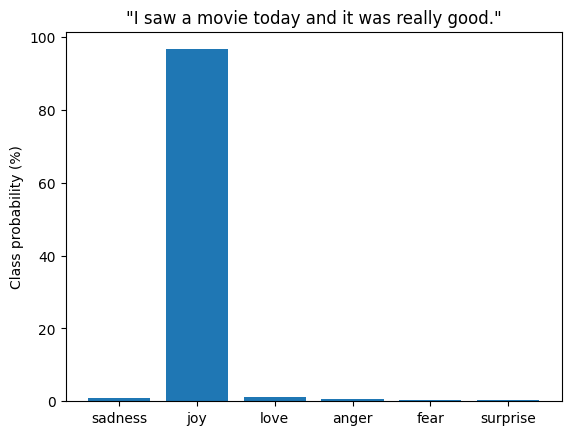

In [69]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()